# **Train Models**
This notebook Trains the following models on the processed train set:

- **Random Forest - Baseline**
- **Random Forest + CNN**
- **XGBoost**
- **Attention-based U-Net**
- **Hybrid SN**


## 1. Setup

### 1.1 Install and Import Libraries

In [ ]:
!pip install \
    scipy \
    numpy \
    pandas \
    scikit-learn \
    tensorflow \
    matplotlib \
    joblib \
    scikit-image \
    opencv-python-headless \
    xgboost


import os
import pickle
import random
import gc
from multiprocessing import Pool
import joblib

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io
from google.colab import drive
from joblib import Parallel, delayed
from scipy.spatial.distance import euclidean
from skimage.transform import resize
from skimage.util import random_noise
from sklearn.decomposition import PCA
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix
)
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
import xgboost as xgb

### 1.2 Setting Seeds

In [ ]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

### 1.3 Connect to Google Drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


### 1.4 Common Functions

In [ ]:
# Used in
# 2.Data Loading,
# 3.3 Remove Noise Channels
def flatten_data(images, labels):
    """
    Flatten the HSI images and labels.

    Parameters:
    - images (list): List of HSI images.
    - labels (list): List of HSI labels.

    Returns:
    - all_data (ndarray): Flattened HSI images.
    - all_labels (ndarray): Flattened HSI labels.
    """
    flattened_images = [image.reshape(-1, image.shape[-1]) for image in images]
    flattened_labels = [label.flatten() for label in labels]

    print("\nCombining flattened data...")
    all_data = np.vstack(flattened_images)
    all_labels = np.hstack(flattened_labels)

    print(f"\nFinal combined data shape: {all_data.shape}")
    print(f"Final combined labels shape: {all_labels.shape}")
    return all_data, all_labels

# Used in
# 2.Data Loading,
# 3.3 Remove Noise Channels
def flatten_data(images, labels):
    """
    Flatten the HSI images and labels.

    Parameters:
    - images (list): List of HSI images.
    - labels (list): List of HSI labels.

    Returns:
    - all_data (ndarray): Flattened HSI images.
    - all_labels (ndarray): Flattened HSI labels.
    """
    flattened_images = [image.reshape(-1, image.shape[-1]) for image in images]
    flattened_labels = [label.flatten() for label in labels]

    print("\nCombining flattened data...")
    all_data = np.vstack(flattened_images)
    all_labels = np.hstack(flattened_labels)

    print(f"\nFinal combined data shape: {all_data.shape}")
    print(f"Final combined labels shape: {all_labels.shape}")
    return all_data, all_labels

def evaluation_report(y_true_tiles, y_pred_tiles, y_proba_tiles, model_title):
    """
    Generate an evaluation report with overall metrics and print a table.

    Parameters:
    - y_true_tiles (array-like): True labels for each tile.
    - y_pred_tiles (array-like): Predicted labels for each tile.
    - y_proba_tiles (array-like): Predicted probabilities for each tile.
    - model_title (str): Title of the model for display purposes.
    """
    # Evaluate overall metrics
    overall_metrics = evaluate_overall(y_true_tiles, y_pred_tiles, y_proba_tiles)

    # Create a DataFrame for the metrics table
    metrics_table = pd.DataFrame({
        "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "AUC"],
        "Value": [
            overall_metrics["Accuracy"],
            overall_metrics["Precision"],
            overall_metrics["Recall"],
            overall_metrics["F1 Score"],
            overall_metrics["AUC"]
        ]
    })

    # Print the metrics table
    print(f"Overall Metrics for {model_title} Model:")
    print(metrics_table.to_string(index=False))

    # Evaluate metrics per tile
    metrics_per_tile, zero_accuracy_tiles, low_recall_tiles, low_precision_tiles = evaluate_metrics_per_tile(
        y_true_tiles, y_pred_tiles
    )

    # Plot histograms with cumulative percentages
    plot_histograms_with_cumulative_percentage(metrics_per_tile)



def evaluate_overall(y_true_tiles, y_pred_tiles, y_proba_tiles):
    """
    Evaluate overall metrics: precision, recall, accuracy, F1 score, and AUC.
    """
    y_true = y_true_tiles.flatten()
    y_pred = y_pred_tiles.flatten()
    y_proba = y_proba_tiles.flatten()

    conf_matrix = confusion_matrix(y_true, y_pred)

    # Handle cases where the confusion matrix may not have all classes
    tp = conf_matrix[1, 1] if conf_matrix.shape == (2, 2) else 0
    tn = conf_matrix[0, 0] if conf_matrix.shape == (2, 2) else 0
    fp = conf_matrix[0, 1] if conf_matrix.shape == (2, 2) else 0
    fn = conf_matrix[1, 0] if conf_matrix.shape == (2, 2) else 0

    precision = tp / (tp + fp) if (tp + fp) > 0 else None
    recall = tp / (tp + fn) if (tp + fn) > 0 else None
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision and recall) else None
    auc = roc_auc_score(y_true, y_proba) if len(np.unique(y_true)) > 1 else None

    return {
        "Confusion Matrix": conf_matrix,
        "Precision": precision,
        "Recall": recall,
        "Accuracy": accuracy,
        "F1 Score": f1_score,
        "AUC": auc,
    }

def flatten_tiles(images, labels):
    """
    Flatten image and label tiles into 2D and 1D arrays, respectively.
    """
    print("Flattening image and label tiles...")
    flattened_images = np.vstack([image.reshape(-1, image.shape[-1]) for image in images])
    flattened_labels = np.vstack([label.flatten() for label in labels])
    print(f"Flattened {len(images)} tiles.")
    return flattened_images, flattened_labels


def load_model(model_path):
    """
    Load a trained model from a file. Supports both scikit-learn and Keras models.

    Parameters:
    - model_path (str): Path to the model file.

    Returns:
    - model: Loaded model.
    """
    print(f"Loading model from {model_path}...")
    if model_path.endswith('.pkl'):
        model = joblib.load(model_path)
    elif model_path.endswith('.h5') or model_path.endswith('.keras'):
        model = tf.keras.models.load_model(model_path)
    else:
        raise ValueError("Unsupported model file format.")
    print("Model loaded successfully.")
    return model


def evaluate_metrics_per_tile(y_pred_tiles, test_labels):
    """
    Evaluate metrics per tile for a test set using a trained model.
    """
    metrics_per_tile = []
    zero_accuracy_tiles = []
    low_recall_tiles = []
    low_precision_tiles = []

    print("Evaluating metrics per tile...")
    for i, (y_pred_tile, y_test_tile) in enumerate(zip(y_pred_tiles, test_labels)):
        # Directly calculate TP, TN, FP, FN
        tp = np.sum((y_test_tile == 1) & (y_pred_tile == 1))  # True Positives
        tn = np.sum((y_test_tile == 0) & (y_pred_tile == 0))  # True Negatives
        fp = np.sum((y_test_tile == 0) & (y_pred_tile == 1))  # False Positives
        fn = np.sum((y_test_tile == 1) & (y_pred_tile == 0))  # False Negatives

        # Handle "no positive ground truth" explicitly
        if np.all(y_test_tile == 0):  # Only water (no positives in ground truth)
            precision = None  # Precision not defined
        else:
            precision = tp / (tp + fp) if (tp + fp) > 0 else None

        # Handle recall (not defined if no positives in ground truth)
        recall = tp / (tp + fn) if (tp + fn) > 0 else None

        # Accuracy
        accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

        # Handle F1 score: set to None if recall is None or zero
        f1_score_tile = (
            2 * (precision * recall) / (precision + recall)
            if (precision is not None and recall is not None and recall > 0)
            else None
        )

        metrics = {
            "precision": precision,
            "recall": recall,
            "accuracy": accuracy,
            "f1_score": f1_score_tile,  # Use the renamed variable
            "tp": tp,
            "tn": tn,
            "fp": fp,
            "fn": fn,
        }

        # Add to specific lists if thresholds are met
        if accuracy == 0:
            zero_accuracy_tiles.append(i)
        if recall is not None and recall < 0.5:  # Example threshold for recall
            low_recall_tiles.append(i)
        if precision is not None and precision < 0.5:  # Example threshold for precision
            low_precision_tiles.append(i)

        metrics_per_tile.append(metrics)
        print(
            f"Tile {i + 1}/{len(test_labels)}: "
            f"TP={tp}, TN={tn}, FP={fp}, FN={fn}, "
            f"Precision={precision}, Recall={recall}, Accuracy={accuracy:.4f}, "
            f"F1 Score={f1_score_tile}"  # Correctly reference the variable here
        )

    return metrics_per_tile, zero_accuracy_tiles, low_recall_tiles, low_precision_tiles


def visualize_label_maps(title,predicted_tiles_labels, test_tiles_labels, tiles_indices="all"):
    """
    Visualize problematic tiles with GT and predicted label maps.

    Parameters:
    - test_labels (list): List of test label tiles (H, W).
    - tiles_indices (list): List of tile indices to visualize.
    - title (str): Title for the visualization (e.g., "Zero Accuracy Tiles").
    """
    if tiles_indices=="all":
        tiles_indices = range(len(test_tiles_labels))

    print(f"Visualizing {len(tiles_indices)} {title.lower()}...")

    for idx in tiles_indices:
        # Get the ground truth label tile
        gt_label = test_tiles_labels[idx]
        pred_label = predicted_tiles_labels[idx]

        # Plot GT and Prediction side by side
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(gt_label, cmap="viridis")
        axes[0].set_title("Ground Truth Label Map")
        axes[0].axis("off")

        axes[1].imshow(pred_label, cmap="viridis")
        axes[1].set_title("Predicted Label Map")
        axes[1].axis("off")

        plt.suptitle(f"{title} - Tile Index: {idx}", fontsize=14)
        plt.tight_layout()
        plt.show()



def plot_histograms_with_cumulative_percentage(metrics_per_tile):
    """
    Plot histograms and cumulative percentages for evaluation metrics across tiles,
    excluding None values from metrics.
    """
    print("Plotting histograms and cumulative percentages...")
    metrics = ["precision", "recall", "accuracy", "f1_score"]
    threshold = 0.7  # Threshold for metrics

    stability_metrics = {}

    # Extract valid values for each metric
    for metric in metrics:
        values = [m[metric] for m in metrics_per_tile if m[metric] is not None]
        stability_metrics[metric] = {
            "values": np.sort(values),  # Sorted for cumulative percentage
        }
        # Debugging: Print extracted values for each metric
        print(f"Metric: {metric}, Valid Values: {values}")

    # Plot histograms and cumulative percentages
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    for idx, (metric, stats) in enumerate(stability_metrics.items()):
        values = stats["values"]

        if len(values) == 0:  # Skip empty metrics
            print(f"Metric {metric} has no valid values. Skipping.")
            continue

        cumulative_percentage = np.arange(1, len(values) + 1) / len(values) * 100

        ax1 = axes[idx]
        ax2 = ax1.twinx()

        # Plot histogram
        ax1.hist(values, bins=10, alpha=0.6, color="#3498db", edgecolor="black", label="Frequency")
        ax1.set_xlabel(metric.capitalize())
        ax1.set_ylabel("Frequency", color="#3498db")
        ax1.tick_params(axis='y', labelcolor="#3498db")

        # Plot cumulative percentage
        ax2.plot(values, cumulative_percentage, color="#e74c3c", linestyle="-", marker=".", label="Cumulative %")
        ax2.set_ylabel("Cumulative Percentage", color="#e74c3c")
        ax2.tick_params(axis='y', labelcolor="#e74c3c")

        # Mark the threshold
        below_threshold = np.sum(values < threshold) / len(values) * 100
        ax1.axvline(x=threshold, color='#2ecc71', linestyle='--', label=f'{metric.capitalize()} = {threshold}')
        ax2.axhline(y=below_threshold, color='#f1c40f', linestyle='--', label=f'< {threshold}: {below_threshold:.2f}%')

        # Legends and grid
        ax1.legend(loc="upper left")
        ax2.legend(loc="upper right")
        ax1.grid()

    plt.tight_layout()
    plt.suptitle("Histograms and Cumulative Percentages of Metrics Across Tiles", fontsize=16, y=1.02)
    plt.show()


def flat_prediction_to_tile_shape(flat_pred, test_labels):
    """
    Convert a flattened prediction back to the original tile shape.
    Handles predictions with multiple output dimensions (e.g., probabilities).
    """
    pred_tiles = []
    start_idx = 0

    for idx, label in enumerate(test_labels):
        original_shape = label.shape
        num_pixels = np.prod(original_shape)

        # Check if flat_pred has multiple dimensions (e.g., probabilities for two classes)
        if flat_pred.ndim > 1:
            # Take only the relevant column (e.g., class 1 probabilities)
            flat_pred = flat_pred[:, 1]

        # Ensure the segment size matches the expected number of pixels
        segment = flat_pred[start_idx:start_idx + num_pixels]
        if segment.size != num_pixels:
            raise ValueError(
                f"Mismatch: expected {num_pixels} pixels, got {segment.size} pixels."
            )

        # Reshape and append
        pred_tile = segment.reshape(original_shape)
        pred_tiles.append(pred_tile)
        start_idx += num_pixels

    return pred_tiles

## 2. Load Processed Dataset

In [ ]:
import numpy as np

# Define the number of PCA components dynamically
n_components = 32  # Change this value as needed
base_save_path = "/content/drive/MyDrive/DataSets/HSI-Augmented-Splitted"

# Generate dynamic paths
save_paths = {
    "train_data": f"{base_save_path}/TrainTiles_{n_components}PCA_normalized.npz",
    "val_data": f"{base_save_path}/ValTiles_{n_components}PCA_normalized.npz",
    "test_data": f"{base_save_path}/TestTiles_{n_components}PCA_normalized.npz",
    "train_labels": f"{base_save_path}/TrainLabels_{n_components}PCA_normalized.npz",
    "val_labels": f"{base_save_path}/ValLabels_{n_components}PCA_normalized.npz",
    "test_labels": f"{base_save_path}/TestLabels_{n_components}PCA_normalized.npz",
    "test_masks": f"{base_save_path}/TestMasks_{n_components}PCA_normalized.npz"
}

def load_npz_as_list(file_path):
    """
    Load data from an .npz file and return a list of arrays.

    Parameters:
    - file_path (str): Path to the .npz file.

    Returns:
    - data_list (list): List of arrays from the .npz file.
    """
    print(f"Loading data from {file_path}...")
    data = np.load(file_path, allow_pickle=True)
    data_list = [data[key] for key in data.files]
    print(f"Loaded {len(data_list)} items from {file_path}")
    return data_list

# Load the data
train_images = load_npz_as_list(save_paths["train_data"])
val_images = load_npz_as_list(save_paths["val_data"])
test_images = load_npz_as_list(save_paths["test_data"])

train_labels = load_npz_as_list(save_paths["train_labels"])
val_labels = load_npz_as_list(save_paths["val_labels"])
test_labels = load_npz_as_list(save_paths["test_labels"])

# Load test masks
print(f"Loading test masks from {save_paths['test_masks']}...")
test_masks = np.load(save_paths["test_masks"], allow_pickle=True)['test_masks']
print(f"Loaded test masks with shape: {test_masks.shape}")

# Print shapes to verify
print("\nVerification:")
print(f"Loaded train_images: {len(train_images)} tiles")
print(f"Loaded val_images: {len(val_images)} tiles")
print(f"Loaded test_images: {len(test_images)} tiles")

print(f"Loaded train_labels: {len(train_labels)} labels")
print(f"Loaded val_labels: {len(val_labels)} labels")
print(f"Loaded test_labels: {len(test_labels)} labels")

Loading data from /content/drive/MyDrive/DataSets/HSI-Augmented-Splitted/TrainTiles_32PCA_normalized.npz...
Loaded 6804 items from /content/drive/MyDrive/DataSets/HSI-Augmented-Splitted/TrainTiles_32PCA_normalized.npz
Loading data from /content/drive/MyDrive/DataSets/HSI-Augmented-Splitted/ValTiles_32PCA_normalized.npz...
Loaded 759 items from /content/drive/MyDrive/DataSets/HSI-Augmented-Splitted/ValTiles_32PCA_normalized.npz
Loading data from /content/drive/MyDrive/DataSets/HSI-Augmented-Splitted/TestTiles_32PCA_normalized.npz...
Loaded 780 items from /content/drive/MyDrive/DataSets/HSI-Augmented-Splitted/TestTiles_32PCA_normalized.npz
Loading data from /content/drive/MyDrive/DataSets/HSI-Augmented-Splitted/TrainLabels_32PCA_normalized.npz...
Loaded 6804 items from /content/drive/MyDrive/DataSets/HSI-Augmented-Splitted/TrainLabels_32PCA_normalized.npz
Loading data from /content/drive/MyDrive/DataSets/HSI-Augmented-Splitted/ValLabels_32PCA_normalized.npz...
Loaded 759 items from /cont

The following code prints the distribution of each label

In [ ]:
import numpy as np

def calculate_label_distribution(labels):
    """
    Calculate the percentage distribution of labels (0 and 1).

    Parameters:
    - labels (list of numpy arrays): List of label tiles.

    Returns:
    - dict: Dictionary with the percentage of each label.
    """
    # Flatten all label tiles into a single array
    all_labels = np.hstack([label.flatten() for label in labels])

    # Count occurrences of each label
    total_count = len(all_labels)
    water_count = np.sum(all_labels == 0)
    oil_count = np.sum(all_labels == 1)

    # Calculate percentages
    water_percentage = (water_count / total_count) * 100
    oil_percentage = (oil_count / total_count) * 100

    return {"Water (0)": water_percentage, "Oil (1)": oil_percentage}

# Calculate distributions
train_distribution = calculate_label_distribution(train_labels)
val_distribution = calculate_label_distribution(val_labels)
test_distribution = calculate_label_distribution(test_labels)

# Print results
print("Label Distribution in Training Set:", train_distribution)
print("Label Distribution in Validation Set:", val_distribution)
print("Label Distribution in Test Set:", test_distribution)

# Calculate overall distribution
all_labels = train_labels + val_labels + test_labels
overall_distribution = calculate_label_distribution(all_labels)
print("Label Distribution in Entire Dataset:", overall_distribution)

Label Distribution in Training Set: {'Water (0)': 90.07933637382422, 'Oil (1)': 9.920663626175779}
Label Distribution in Validation Set: {'Water (0)': 94.94239696557972, 'Oil (1)': 5.05760303442029}
Label Distribution in Test Set: {'Water (0)': 94.6806139823718, 'Oil (1)': 5.319386017628205}
Label Distribution in Entire Dataset: {'Water (0)': 90.95193130655939, 'Oil (1)': 9.048068693440609}


In [ ]:
gc.collect()

627

## 3. Random Forest - Baseline

In [ ]:
# --- Model Training Functions ---
def train_rf(train_images, train_labels, model_name):
    """
    Train a Random Forest model.
    """
    # Flatten train data
    print("Flattening training data...")
    train_images_flattened, train_labels_flattened = flatten_tiles(train_images, train_labels)

    # Combine training data
    X_train = np.vstack(train_images_flattened).astype("float16")
    y_train = np.hstack(train_labels_flattened).astype("int8")
    del train_images_flattened, train_labels_flattened
    gc.collect()

    # Train the Random Forest model
    print("Training Random Forest Classifier...")
    rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_features="sqrt")
    rf.fit(X_train, y_train)
    print("Random Forest training completed.")

    # Save the model
    model_path = f"/content/drive/MyDrive/HSI MODELS/random_forest_{model_name}.pkl"
    joblib.dump(rf, model_path)
    print(f"Model saved to {model_path}")

    # Clean up training data
    del X_train, y_train
    gc.collect()

    return rf


In [ ]:
rf = train_rf(train_images, train_labels, " PCA 32 - Normalized")

## 4. Random Forest + CNN

Loading RF model from /content/drive/MyDrive/HSI MODELS/random_forest_ PCA 32 - Normalized _ no downsample.pkl...
RF model loaded successfully.
Flattening test and validation data...
Making predictions with RF...
Predictions reshaped successfully.
Preparing validation data for CNN...
Shape of val_train_rf: (607, 64, 64, 1)
Shape of val_train_labels: (607, 64, 64, 1)
Starting dataset augmentation.
Processing image 1/607 with shape (64, 64, 1).
Applying augmentations to the image and label.
Total augmentations for this image: 5
Processing image 2/607 with shape (64, 64, 1).
Skipping augmentation for image 2 (only water).
Processing image 3/607 with shape (64, 64, 1).
Applying augmentations to the image and label.
Total augmentations for this image: 5
Processing image 4/607 with shape (64, 64, 1).
Skipping augmentation for image 4 (only water).
Processing image 5/607 with shape (64, 64, 1).
Applying augmentations to the image and label.
Total augmentations for this image: 5
Processing ima

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 64, 64, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 64, 64, 32)     │            320 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 64, 64, 32)     │          9,248 │ conv2d_10[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 32, 32, 32)     │              0 │ conv2d_11[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 32, 32, 64)     │         18,496 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 32, 32, 64)     │         36,928 │ conv2d_12[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 16, 16, 64)     │              0 │ conv2d_13[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 16, 16, 128)    │         73,856 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 16, 16, 128)    │        147,584 │ conv2d_14[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 8, 8, 128)      │              0 │ conv2d_15[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_3        │ (None, 16, 16, 128)    │         65,664 │ max_pooling2d_5[0][0]  │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 16, 16, 256)    │              0 │ conv2d_transpose_3[0]… │
│ (Concatenate)             │                        │                │ conv2d_15[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 16, 16, 128)    │        295,040 │ concatenate_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_4        │ (None, 32, 32, 64)     │         32,832 │ conv2d_16[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4             │ (None, 32, 32, 128)    │              0 │ conv2d_transpose_4[0]… │
│ (Concatenate)             │                        │                │ conv2d_13[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)   

 Total params: 780,481 (2.98 MB)

 Trainable params: 780,481 (2.98 MB)

 Non-trainable params: 0 (0.00 B)

Training CNN...
Epoch 1/50
1070/1076 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9568 - auc: 0.9568 - loss: 0.1166 - precision: 0.7670 - recall: 0.7346
Epoch 1: val_auc improved from -inf to 0.98529, saving model to /content/drive/MyDrive/HSI MODELS/best_rf_cnn_model_normalized_augmented.keras
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.9569 - auc: 0.9570 - loss: 0.1163 - precision: 0.7674 - recall: 0.7351 - val_accuracy: 0.9846 - val_auc: 0.9853 - val_loss: 0.0418 - val_precision: 0.8842 - val_recall: 0.7630 - learning_rate: 0.0010
Epoch 2/50
1063/1076 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9712 - auc: 0.9901 - loss: 0.0678 - precision: 0.8501 - recall: 0.8219
Epoch 2: val_auc improved from 0.98529 to 0.98844, saving model to /content/drive/MyDrive/HSI MODELS/best_rf_cnn_model_normalized_augmented.keras
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9712 - auc: 0.9901 - loss: 0.0678 - precision: 0.8501 - recall: 0.8219 - val_accuracy: 0.9846 - val_au

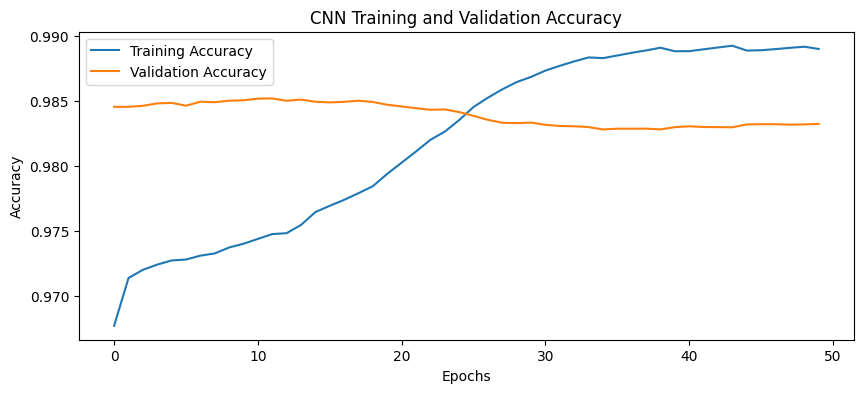

In [ ]:
# --- Load RF Model and Make Predictions ---
from tensorflow.keras import layers
from tensorflow.keras import models
def reshape_predictions(flat_predictions, tile_size):
    """
    Reshape flat predictions back to original tile shapes.
    """
    reshaped_predictions = []
    num_pixels = tile_size[0] * tile_size[1]
    for i in range(len(flat_predictions) // num_pixels):
        reshaped_predictions.append(
            flat_predictions[i * num_pixels: (i + 1) * num_pixels].reshape((tile_size[0], tile_size[1], 1))
        )
    return np.array(reshaped_predictions)


def load_rf_and_predict(model_path, test_images, val_images, tile_size):
    """
    Load the RF model and use it to predict probabilities for the test and validation datasets.
    """
    print(f"Loading RF model from {model_path}...")
    rf = joblib.load(model_path)
    print("RF model loaded successfully.")

    # Flatten test and validation data
    print("Flattening test and validation data...")
    test_images_flattened = np.vstack([image.reshape(-1, image.shape[-1]) for image in test_images]).astype("float16")
    val_images_flattened = np.vstack([image.reshape(-1, image.shape[-1]) for image in val_images]).astype("float16")

    # Make predictions
    print("Making predictions with RF...")
    test_rf_probs = rf.predict_proba(test_images_flattened)[:, 1]
    val_rf_probs = rf.predict_proba(val_images_flattened)[:, 1]

    # Reshape predictions back to original tile sizes

    reshaped_test_rf = reshape_predictions(test_rf_probs, tile_size)
    reshaped_val_rf = reshape_predictions(val_rf_probs, tile_size)

    print("Predictions reshaped successfully.")
    return reshaped_test_rf, reshaped_val_rf


# --- CNN Model Definition ---
def create_cnn(input_shape):
    """
    Create a CNN model for refining RF predictions.
    """
    inputs = layers.Input(input_shape)

    # Convolutional Layers
    c1 = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
    c1 = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(p1)
    c2 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(p2)
    c3 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Upsampling Layers
    u1 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(p3)
    u1 = layers.concatenate([u1, c3])
    u1 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(u1)

    u2 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(u1)
    u2 = layers.concatenate([u2, c2])
    u2 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(u2)

    u3 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding="same")(u2)
    u3 = layers.concatenate([u3, c1])
    u3 = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(u3)

    # Output Layer
    outputs = layers.Conv2D(1, (1, 1), activation="sigmoid")(u3)
    model = models.Model(inputs, outputs)
    return model


# --- Main Function ---
def train_cnn_with_rf_predictions(val_rf_probs, val_labels, tile_size):
    """
    Train a CNN using RF predictions as input and evaluate on a validation set.
    """
    print("Preparing validation data for CNN...")
    val_rf_probs = np.array(val_rf_probs)  # RF predictions for validation set
    val_labels = np.array(val_labels)  # Ground truth labels for validation set

    # Split validation set into training and evaluation subsets
    val_train_rf, val_eval_rf, val_train_labels, val_eval_labels = train_test_split(
        val_rf_probs, val_labels, test_size=0.2, random_state=42
    )

    print(f"Shape of val_train_rf: {val_train_rf.shape}")
    print(f"Shape of val_train_labels: {val_train_labels.shape}")





    # Create CNN model
    print("Creating CNN model...")
    cnn_model = create_cnn(tile_size + (1,))
    cnn_model.summary()

   # Learning rate scheduler: Reduce learning rate on plateau
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',  # Monitor validation loss
        factor=0.5,          # Reduce learning rate by a factor of 0.5
        patience=5,          # Wait for 5 epochs without improvement
        min_lr=1e-6          # Minimum learning rate
    )
    # Model Checkpoint
    model_checkpoint = ModelCheckpoint(
        filepath="/content/drive/MyDrive/HSI MODELS/best_rf_cnn_model_normalized_augmented.keras",
        monitor="val_auc",
        mode="max",
        save_best_only=True,
        verbose=1,
    )

    # Compile the model
    cnn_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            tf.keras.metrics.AUC(name="auc"),
            tf.keras.metrics.Recall(name="recall"),
            tf.keras.metrics.Precision(name="precision"),
        ],
    )

    # Train the model
    print("Training CNN...")
    history = cnn_model.fit(
        np.array(val_train_rf),
        np.array(val_train_labels),
        epochs=50,
        batch_size=2,
        validation_data=(val_eval_rf, val_eval_labels),
        callbacks=[lr_scheduler, model_checkpoint],
    )

    print("CNN training completed.")
    return cnn_model, history


# --- Execution ---
# Load the RF model and make predictions
model_path = "/content/drive/MyDrive/HSI MODELS/random_forest_ PCA 32 - Normalized _ no downsample.pkl"
tile_size = (64, 64)
reshaped_test_rf, reshaped_val_rf = load_rf_and_predict(model_path, test_images, val_images, tile_size)

# Train CNN using RF predictions
cnn_model, history = train_cnn_with_rf_predictions(reshaped_val_rf, val_labels, tile_size)

# Plot Training History
plt.figure(figsize=(10, 4))
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("CNN Training and Validation Accuracy")
plt.show()




# Extract training and validation metrics from history
history_dict = history.history

# Define the metrics you want to plot
metrics = ['accuracy', 'auc', 'recall', 'precision', 'loss']

# Create subplots for each metric
for metric in metrics:
    plt.figure()
    plt.plot(history_dict[metric], label=f'Training {metric.capitalize()}')
    plt.plot(history_dict[f'val_{metric}'], label=f'Validation {metric.capitalize()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.title(f'{metric.capitalize()} Over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

# Calculate F1 Score
train_precision = np.array(history_dict['precision'])
train_recall = np.array(history_dict['recall'])
train_f1 = 2 * (train_precision * train_recall) / (train_precision + train_recall + 1e-8)

val_precision = np.array(history_dict['val_precision'])
val_recall = np.array(history_dict['val_recall'])
val_f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall + 1e-8)

# Plot the F1 Score
plt.figure()
plt.plot(train_f1, label='Training F1 Score')
plt.plot(val_f1, label='Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('F1 Score Over Epochs')
plt.legend()
plt.grid()
plt.show()

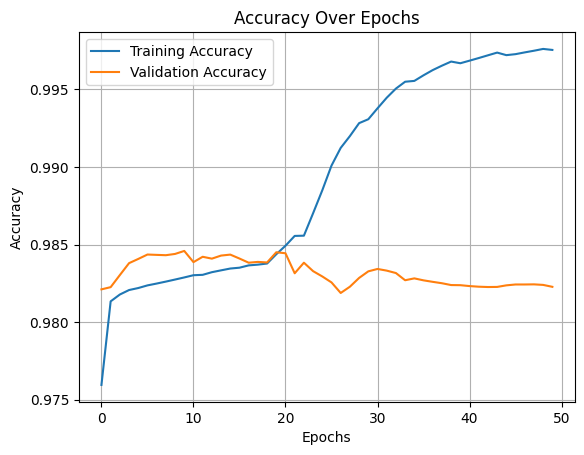

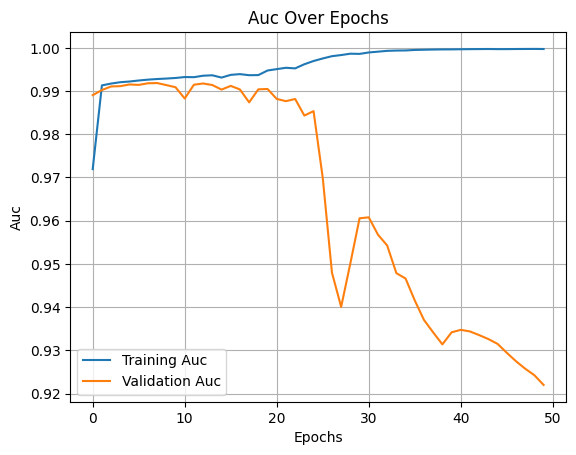

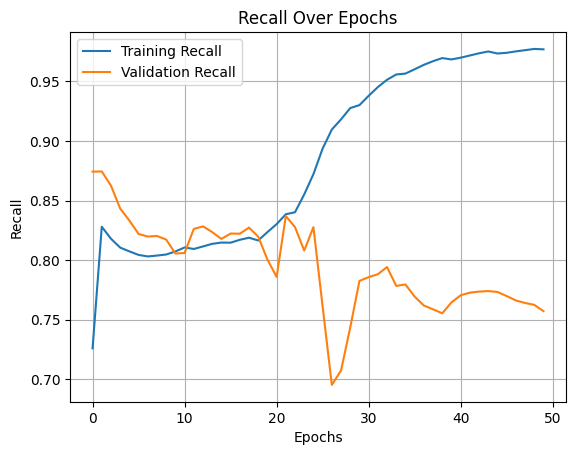

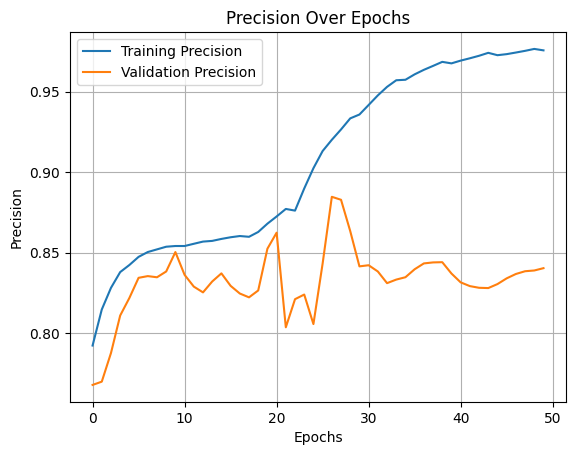

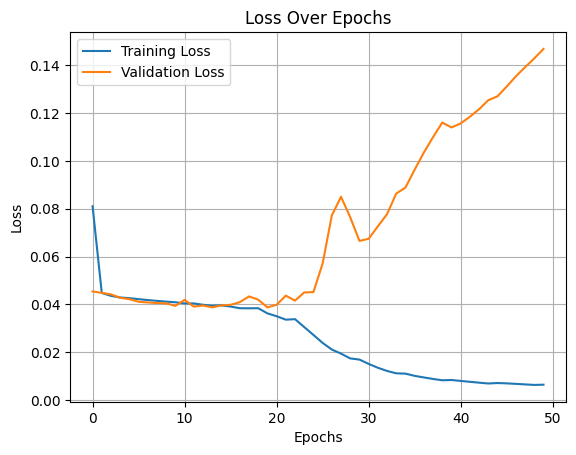

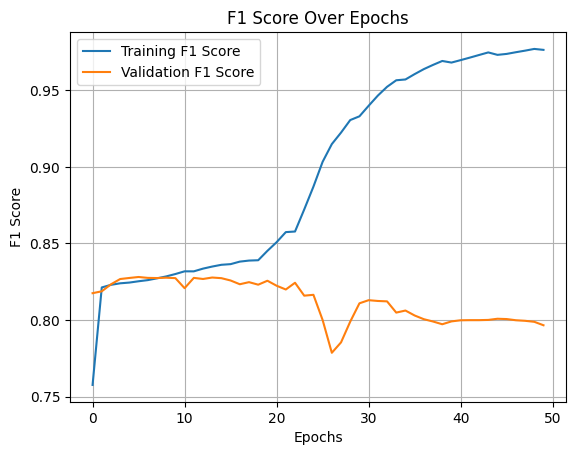

## 5. XGBoost


In [ ]:
def train_xgb(train_images, train_labels, model_name):
    """
    Train an XGBoost model.
    """
    # Flatten train data
    print("Flattening training data...")
    train_images_flattened, train_labels_flattened = flatten_tiles(train_images, train_labels)

    # Combine training data
    X_train = np.vstack(train_images_flattened).astype("float32")
    y_train = np.hstack(train_labels_flattened).astype("int8")
    del train_images_flattened, train_labels_flattened
    gc.collect()

    # Train the XGBoost model
    print("Training XGBoost Classifier...")
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        tree_method="hist",
        use_label_encoder=False,
        eval_metric="logloss",
    )
    xgb_model.fit(X_train, y_train)
    print("XGBoost training completed.")

    # Save the model
    model_path = f"/content/drive/MyDrive/HSI MODELS/xgboost_{model_name}.pkl"
    joblib.dump(xgb_model, model_path)
    print(f"Model saved to {model_path}")

    # Clean up training data
    del X_train, y_train
    gc.collect()

    return xgb_model





In [ ]:

XGB = train_xgb(train_images, train_labels, "PCA 32 Normalized ")




Flattening training data...
Flattening image and label tiles...
Flattened 6804 tiles.
Training XGBoost Classifier...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:20:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost training completed.
Model saved to /content/drive/MyDrive/HSI MODELS/xgboost_PCA 32 Normalized .pkl


## 6. Attention based U-net

In [ ]:
# 4. U-Net Model Definition
def create_unet(input_shape):
    inputs = layers.Input(input_shape)

    # Encoder with Channel Attention Mechanism (CAM)
    def cam_block(input_tensor):
        avg_pool = layers.GlobalAveragePooling2D()(input_tensor)
        dense1 = layers.Dense(units=input_tensor.shape[-1] // 8, activation='relu')(avg_pool)
        dense2 = layers.Dense(units=input_tensor.shape[-1], activation='sigmoid')(dense1)
        scale = layers.Reshape((1, 1, input_tensor.shape[-1]))(dense2)
        return layers.Multiply()([input_tensor, scale])

    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    c1 = cam_block(c1)  # Apply CAM
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    c2 = cam_block(c2)  # Apply CAM
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)

    # Decoder with Transposed Convolutions
    u1 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c3)
    u1 = layers.concatenate([u1, c2])
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    u2 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
    u2 = layers.concatenate([u2, c1])
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    # Output layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = models.Model(inputs, outputs)
    return model



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64, 64, 32)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 64, 64, 64)     │         18,496 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 64)             │              0 │ conv2d_1[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 8)              │            520 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │            576 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1, 64)       │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 64, 64, 64)     │              0 │ conv2d_1[0][0],        │
│                           │                        │                │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 32, 32, 64)     │              0 │ multiply[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 128)    │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 128)            │              0 │ conv2d_3[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 16)             │          2,064 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 128)            │          2,176 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 1, 1, 128)      │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_1 (Multiply)     │ (None, 32, 32, 128)    │              0 │ conv2d_3[0][0],        │
│                           │                        │                │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 16, 16, 128)    │              0 │ multiply_1[0][0]       │
│ (MaxPooling2D)       

 Total params: 1,884,889 (7.19 MB)

 Trainable params: 1,884,889 (7.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 39s 7ms/step - accuracy: 0.9069 - auc: 0.6201 - loss: 0.3363 - precision: 0.5948 - recall: 0.0670 - lr: 1.3375e-04 - val_accuracy: 0.9599 - val_auc: 0.9275 - val_loss: 0.1195 - val_precision: 0.7513 - val_recall: 0.3090
Epoch 2/20
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9318 - auc: 0.9137 - loss: 0.1828 - precision: 0.7478 - recall: 0.4369 - lr: 1.3375e-04 - val_accuracy: 0.9677 - val_auc: 0.9633 - val_loss: 0.0950 - val_precision: 0.7451 - val_recall: 0.5494
Epoch 3/20
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9418 - auc: 0.9406 - loss: 0.1555 - precision: 0.7751 - recall: 0.5549 - lr: 1.3375e-04 - val_accuracy: 0.9644 - val_auc: 0.9640 - val_loss: 0.0916 - val_precision: 0.8063 - val_recall: 0.3904
Epoch 4/20
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9453 - auc: 0.9514 - loss: 0.1430 - precision: 0.7964 - recall: 0.5784 - lr: 1.3375e-04 - val_accuracy: 0.9700 - val_auc: 0.9719 - val_loss: 0.08

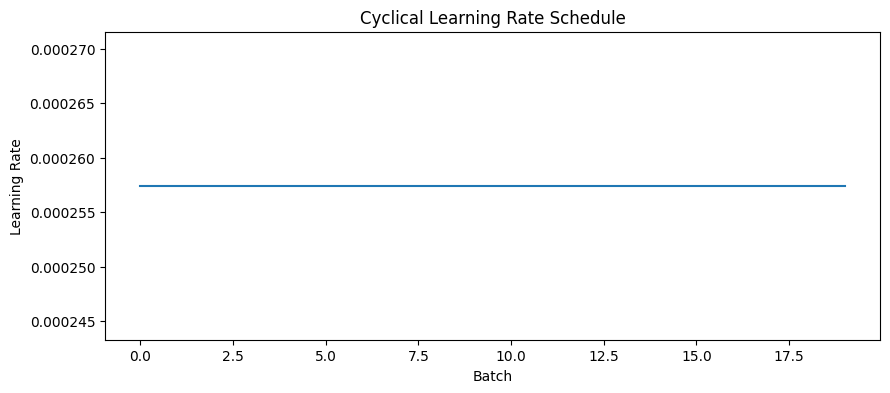

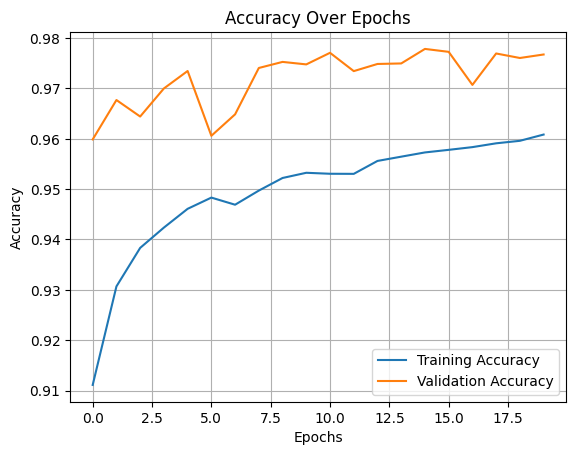

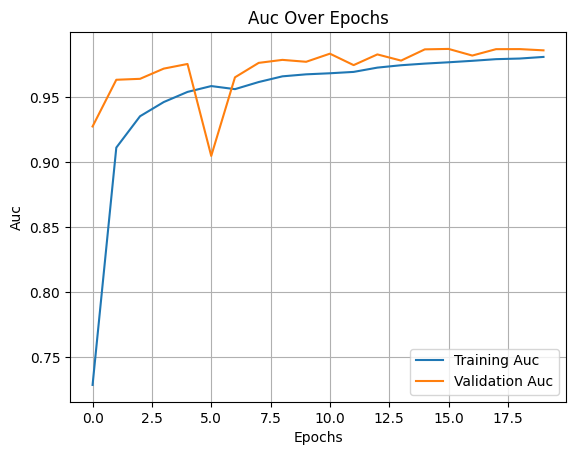

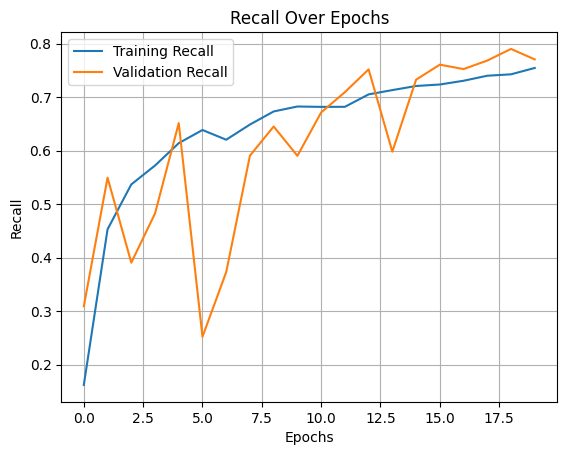

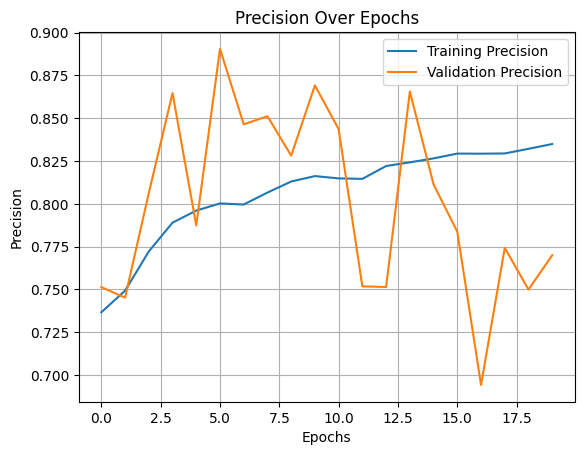

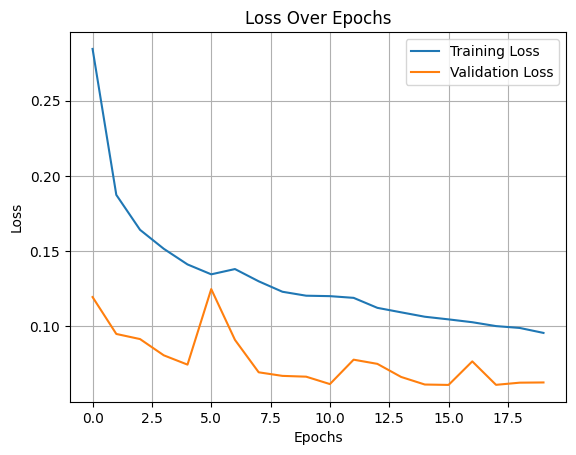

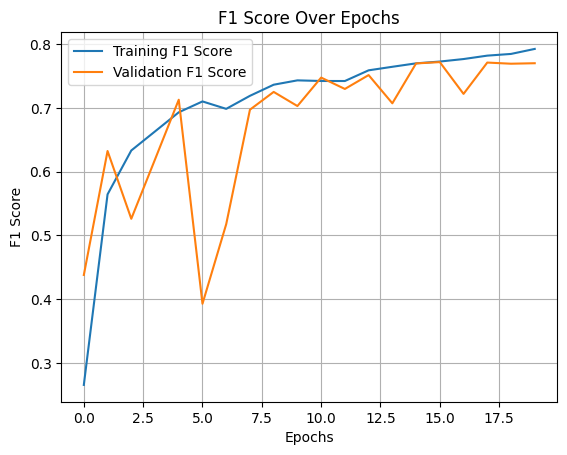

In [ ]:

class CyclicalLearningRate(tf.keras.callbacks.Callback):
    """Custom callback for cyclical learning rate."""
    def __init__(
        self,
        base_lr=1e-5,
        max_lr=1e-3,
        step_size=4,
        mode='triangular'
    ):
        super().__init__()
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.cycle = 0
        self.step_in_cycle = 0

    def on_batch_begin(self, batch, logs=None):
        # Calculate the learning rate
        cycle = np.floor(1 + batch / (2 * self.step_size))
        x = np.abs(batch / self.step_size - 2 * cycle + 1)
        lr = self.base_lr + (self.max_lr - self.base_lr) * max(0, (1 - x))

        # Set the learning rate using assign
        self.model.optimizer._learning_rate.assign(lr)

    def on_batch_end(self, batch, logs=None):
        logs = logs or {}
        logs['lr'] = self.model.optimizer._learning_rate.numpy()

# Create and compile the model
tile_size = (64, 64)
input_shape = (tile_size[0], tile_size[1], 32)
model = create_unet(input_shape)

# Model summary
model.summary()

# Calculate step size based on dataset size
steps_per_epoch = len(train_images) // 2  # batch_size = 2
step_size = steps_per_epoch * 4  # 4 epochs per cycle

# Initialize CLR callback
clr = CyclicalLearningRate(
    base_lr=1e-5,    # Minimum learning rate
    max_lr=1e-3,     # Maximum learning rate
    step_size=step_size,
    mode='triangular'
)

# Model checkpoint callback
model_checkpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/HSI MODELS/best_Attention_UNET_model.keras',
    monitor='val_auc',
    mode='max',
    save_best_only=True
)

# Compile the model with a basic Adam optimizer (CLR will modify its learning rate)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="binary_crossentropy",
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.Precision(name='precision')
    ]
)



# Train the model with CLR
history = model.fit(
    np.array(train_images),
    np.array(train_labels),
    epochs=20,
    batch_size=2,
    validation_data=(np.array(val_images), np.array(val_labels)),
    callbacks=[clr, model_checkpoint]
)

# To visualize the learning rate changes
plt.figure(figsize=(10, 4))
plt.plot(history.history['lr'])
plt.xlabel('Batch')
plt.ylabel('Learning Rate')
plt.title('Cyclical Learning Rate Schedule')
plt.show()


import matplotlib.pyplot as plt
import numpy as np

# Extract training and validation metrics from history
history_dict = history.history

# Define the metrics you want to plot
metrics = ['accuracy', 'auc', 'recall', 'precision', 'loss']

# Create subplots for each metric
for metric in metrics:
    plt.figure()
    plt.plot(history_dict[metric], label=f'Training {metric.capitalize()}')
    plt.plot(history_dict[f'val_{metric}'], label=f'Validation {metric.capitalize()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.title(f'{metric.capitalize()} Over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

# Calculate F1 Score
train_precision = np.array(history_dict['precision'])
train_recall = np.array(history_dict['recall'])
train_f1 = 2 * (train_precision * train_recall) / (train_precision + train_recall + 1e-8)

val_precision = np.array(history_dict['val_precision'])
val_recall = np.array(history_dict['val_recall'])
val_f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall + 1e-8)

# Plot the F1 Score
plt.figure()
plt.plot(train_f1, label='Training F1 Score')
plt.plot(val_f1, label='Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('F1 Score Over Epochs')
plt.legend()
plt.grid()
plt.show()

## 7. Hybrid SN

In [ ]:
from keras.layers import Input, Conv3D, Conv2D, Reshape, Flatten, Dense, Dropout
from keras.models import Model

def create_binary_classification_model(input_shape):
    """
    Create a binary classification model based on the HybridSN architecture
    tailored for pixel-wise binary classification.

    Parameters:
    - input_shape: Tuple representing the shape of the input (S, S, L, 1).

    Returns:
    - model: A compiled Keras model ready for training.
    """
    ## Input layer
    input_layer = Input(input_shape)

    ## 3D-CNN layers for spectral-spatial feature extraction
    conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu', padding='valid')(input_layer)
    conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu', padding='valid')(conv_layer1)
    conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='valid')(conv_layer2)

    ## Reshaping the output for 2D-CNN layers
    conv3d_shape = conv_layer3.shape
    conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3] * conv3d_shape[4]))(conv_layer3)

    ## 2D-CNN layers for higher-level spatial feature learning
    conv_layer4 = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='valid')(conv_layer3)

    ## Flattening for fully connected layers
    flatten_layer = Flatten()(conv_layer4)

    ## Fully connected layers with dropout for regularization
    dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
    dense_layer1 = Dropout(0.4)(dense_layer1)
    dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
    dense_layer2 = Dropout(0.4)(dense_layer2)

    ## Output layer for binary classification
    output_layer = Dense(units=1, activation='sigmoid')(dense_layer2)

    ## Model definition
    model = Model(inputs=input_layer, outputs=output_layer)

    ## Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model



In [ ]:

class CyclicalLearningRate(tf.keras.callbacks.Callback):
    """Custom callback for cyclical learning rate."""
    def __init__(
        self,
        base_lr=1e-5,
        max_lr=1e-3,
        step_size=4,
        mode='triangular'
    ):
        super().__init__()
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.cycle = 0
        self.step_in_cycle = 0

    def on_batch_begin(self, batch, logs=None):
        # Calculate the learning rate
        cycle = np.floor(1 + batch / (2 * self.step_size))
        x = np.abs(batch / self.step_size - 2 * cycle + 1)
        lr = self.base_lr + (self.max_lr - self.base_lr) * max(0, (1 - x))

        # Set the learning rate using assign
        self.model.optimizer._learning_rate.assign(lr)

    def on_batch_end(self, batch, logs=None):
        logs = logs or {}
        logs['lr'] = self.model.optimizer._learning_rate.numpy()

# Create and compile the model
tile_size = (64, 64)
input_shape = (tile_size[0], tile_size[1], 32,1)
# Create and summarize the model
model = create_pixelwise_classification_model(input_shape)



# Model summary
model.summary()

# Calculate step size based on dataset size
steps_per_epoch = len(train_images) // 2  # batch_size = 2
step_size = steps_per_epoch * 4  # 4 epochs per cycle

# Initialize CLR callback
clr = CyclicalLearningRate(
    base_lr=1e-5,    # Minimum learning rate
    max_lr=1e-3,     # Maximum learning rate
    step_size=step_size,
    mode='triangular'
)

# Model checkpoint callback
model_checkpoint = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_auc',
    mode='max',
    save_best_only=True
)

# Compile the model with a basic Adam optimizer (CLR will modify its learning rate)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="binary_crossentropy",
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.Precision(name='precision')
    ]
)



# Train the model with CLR
history = model.fit(
    np.array(train_images),
    np.array(train_labels),
    epochs=100,
    batch_size=2,
    validation_data=(np.array(val_images), np.array(val_labels)),
    callbacks=[clr, model_checkpoint]
)

# To visualize the learning rate changes
plt.figure(figsize=(10, 4))
plt.plot(history.history['lr'])
plt.xlabel('Batch')
plt.ylabel('Learning Rate')
plt.title('Cyclical Learning Rate Schedule')
plt.show()


import matplotlib.pyplot as plt
import numpy as np

# Extract training and validation metrics from history
history_dict = history.history

# Define the metrics you want to plot
metrics = ['accuracy', 'auc', 'recall', 'precision', 'loss']

# Create subplots for each metric
for metric in metrics:
    plt.figure()
    plt.plot(history_dict[metric], label=f'Training {metric.capitalize()}')
    plt.plot(history_dict[f'val_{metric}'], label=f'Validation {metric.capitalize()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.title(f'{metric.capitalize()} Over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

# Calculate F1 Score
train_precision = np.array(history_dict['precision'])
train_recall = np.array(history_dict['recall'])
train_f1 = 2 * (train_precision * train_recall) / (train_precision + train_recall + 1e-8)

val_precision = np.array(history_dict['val_precision'])
val_recall = np.array(history_dict['val_recall'])
val_f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall + 1e-8)

# Plot the F1 Score
plt.figure()
plt.plot(train_f1, label='Training F1 Score')
plt.plot(val_f1, label='Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('F1 Score Over Epochs')
plt.legend()
plt.grid()
plt.show()

Model: "functional_2"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 64, 64, 32, 1)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_6 (Conv3D)                    │ (None, 64, 64, 32, 8)       │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_7 (Conv3D)                    │ (None, 64, 64, 32, 16)      │           5,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_8 (Conv3D)                    │ (None, 64, 64, 32, 32)      │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 64, 64, 1024)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 64)          │         589,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 64, 64, 1)           │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘
 Total params: 610,097 (2.33 MB)
 Trainable params: 610,097 (2.33 MB)
 Non-trainable params: 0 (0.00 B)
Epoch 1/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 60s 15ms/step - accuracy: 0.8906 - auc: 0.6009 - loss: 0.3386 - precision: 0.3737 - recall: 0.0597 - lr: 1.3375e-04 - val_accuracy: 0.9585 - val_auc: 0.9158 - val_loss: 0.1329 - val_precision: 0.7906 - val_recall: 0.2431
Epoch 2/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 46s 13ms/step - accuracy: 0.9284 - auc: 0.8762 - loss: 0.2070 - precision: 0.7833 - recall: 0.3522 - lr: 1.3375e-04 - val_accuracy: 0.9669 - val_auc: 0.9501 - val_loss: 0.1079 - val_precision: 0.7693 - val_recall: 0.4947
Epoch 3/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9374 - auc: 0.9211 - loss: 0.1754 - precision: 0.7849 - recall: 0.4796 - lr: 1.3375e-04 - val_accuracy: 0.9684 - val_auc: 0.9576 - val_loss: 0.1126 - val_precision: 0.7261 - val_recall: 0.6026
Epoch 4/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9408 - auc: 0.9377 - loss: 0.1599 - precision: 0.7887 - recall: 0.5243 - lr: 1.3375e-04 - val_accuracy: 0.9694 - val_auc: 0.9635 - val_loss: 0.1083 - val_precision: 0.7053 - val_recall: 0.6785
Epoch 5/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9448 - auc: 0.9473 - loss: 0.1483 - precision: 0.8008 - recall: 0.5666 - lr: 1.3375e-04 - val_accuracy: 0.9712 - val_auc: 0.9702 - val_loss: 0.0992 - val_precision: 0.7172 - val_recall: 0.7104
Epoch 6/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9475 - auc: 0.9537 - loss: 0.1403 - precision: 0.8074 - recall: 0.5958 - lr: 1.3375e-04 - val_accuracy: 0.9721 - val_auc: 0.9727 - val_loss: 0.0912 - val_precision: 0.7276 - val_recall: 0.7179
Epoch 7/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9494 - auc: 0.9578 - loss: 0.1347 - precision: 0.8091 - recall: 0.6190 - lr: 1.3375e-04 - val_accuracy: 0.9733 - val_auc: 0.9780 - val_loss: 0.0827 - val_precision: 0.7390 - val_recall: 0.7306
Epoch 8/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9507 - auc: 0.9615 - loss: 0.1297 - precision: 0.8096 - recall: 0.6363 - lr: 1.3375e-04 - val_accuracy: 0.9742 - val_auc: 0.9805 - val_loss: 0.0776 - val_precision: 0.7459 - val_recall: 0.7428
Epoch 9/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9520 - auc: 0.9644 - loss: 0.1253 - precision: 0.8125 - recall: 0.6495 - lr: 1.3375e-04 - val_accuracy: 0.9745 - val_auc: 0.9819 - val_loss: 0.0729 - val_precision: 0.7466 - val_recall: 0.7494
Epoch 10/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 46s 13ms/step - accuracy: 0.9530 - auc: 0.9666 - loss: 0.1219 - precision: 0.8126 - recall: 0.6631 - lr: 1.3375e-04 - val_accuracy: 0.9739 - val_auc: 0.9833 - val_loss: 0.0730 - val_precision: 0.7331 - val_recall: 0.7607
Epoch 11/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9535 - auc: 0.9678 - loss: 0.1200 - precision: 0.8120 - recall: 0.6716 - lr: 1.3375e-04 - val_accuracy: 0.9746 - val_auc: 0.9844 - val_loss: 0.0682 - val_precision: 0.7426 - val_recall: 0.7614
Epoch 12/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9545 - auc: 0.9695 - loss: 0.1170 - precision: 0.8147 - recall: 0.6802 - lr: 1.3375e-04 - val_accuracy: 0.9751 - val_auc: 0.9858 - val_loss: 0.0640 - val_precision: 0.7570 - val_recall: 0.7467
Epoch 13/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9550 - auc: 0.9713 - loss: 0.1146 - precision: 0.8119 - recall: 0.6918 - lr: 1.3375e-04 - val_accuracy: 0.9752 - val_auc: 0.9853 - val_loss: 0.0626 - val_precision: 0.7646 - val_recall: 0.7365
Epoch 14/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9557 - auc: 0.9722 - loss: 0.1126 - precision: 0.8139 - recall: 0.6975 - lr: 1.3375e-04 - val_accuracy: 0.9760 - val_auc: 0.9864 - val_loss: 0.0622 - val_precision: 0.7778 - val_recall: 0.7365
Epoch 15/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9563 - auc: 0.9732 - loss: 0.1108 - precision: 0.8175 - recall: 0.7012 - lr: 1.3375e-04 - val_accuracy: 0.9767 - val_auc: 0.9872 - val_loss: 0.0588 - val_precision: 0.7840 - val_recall: 0.7439
Epoch 16/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9569 - auc: 0.9741 - loss: 0.1091 - precision: 0.8204 - recall: 0.7046 - lr: 1.3375e-04 - val_accuracy: 0.9774 - val_auc: 0.9872 - val_loss: 0.0599 - val_precision: 0.7863 - val_recall: 0.7594
Epoch 17/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9574 - auc: 0.9748 - loss: 0.1076 - precision: 0.8235 - recall: 0.7073 - lr: 1.3375e-04 - val_accuracy: 0.9770 - val_auc: 0.9874 - val_loss: 0.0602 - val_precision: 0.7888 - val_recall: 0.7448
Epoch 18/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 46s 13ms/step - accuracy: 0.9575 - auc: 0.9751 - loss: 0.1074 - precision: 0.8249 - recall: 0.7074 - lr: 1.3375e-04 - val_accuracy: 0.9780 - val_auc: 0.9881 - val_loss: 0.0550 - val_precision: 0.8051 - val_recall: 0.7446
Epoch 19/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9582 - auc: 0.9759 - loss: 0.1053 - precision: 0.8263 - recall: 0.7153 - lr: 1.3375e-04 - val_accuracy: 0.9778 - val_auc: 0.9881 - val_loss: 0.0573 - val_precision: 0.7972 - val_recall: 0.7515
Epoch 20/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9584 - auc: 0.9764 - loss: 0.1048 - precision: 0.8263 - recall: 0.7166 - lr: 1.3375e-04 - val_accuracy: 0.9785 - val_auc: 0.9890 - val_loss: 0.0535 - val_precision: 0.8136 - val_recall: 0.7447
Epoch 21/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9590 - auc: 0.9771 - loss: 0.1029 - precision: 0.8288 - recall: 0.7220 - lr: 1.3375e-04 - val_accuracy: 0.9784 - val_auc: 0.9888 - val_loss: 0.0534 - val_precision: 0.8115 - val_recall: 0.7471
Epoch 22/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9592 - auc: 0.9774 - loss: 0.1023 - precision: 0.8287 - recall: 0.7242 - lr: 1.3375e-04 - val_accuracy: 0.9782 - val_auc: 0.9885 - val_loss: 0.0564 - val_precision: 0.8092 - val_recall: 0.7442
Epoch 23/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9591 - auc: 0.9772 - loss: 0.1027 - precision: 0.8291 - recall: 0.7224 - lr: 1.3375e-04 - val_accuracy: 0.9776 - val_auc: 0.9885 - val_loss: 0.0544 - val_precision: 0.8057 - val_recall: 0.7349
Epoch 24/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9590 - auc: 0.9774 - loss: 0.1022 - precision: 0.8267 - recall: 0.7244 - lr: 1.3375e-04 - val_accuracy: 0.9782 - val_auc: 0.9889 - val_loss: 0.0543 - val_precision: 0.8091 - val_recall: 0.7441
Epoch 25/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9595 - auc: 0.9780 - loss: 0.1014 - precision: 0.8303 - recall: 0.7256 - lr: 1.3375e-04 - val_accuracy: 0.9781 - val_auc: 0.9891 - val_loss: 0.0532 - val_precision: 0.8010 - val_recall: 0.7532
Epoch 26/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9594 - auc: 0.9781 - loss: 0.1011 - precision: 0.8260 - recall: 0.7303 - lr: 1.3375e-04 - val_accuracy: 0.9789 - val_auc: 0.9897 - val_loss: 0.0521 - val_precision: 0.8221 - val_recall: 0.7438
Epoch 27/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9598 - auc: 0.9787 - loss: 0.1000 - precision: 0.8300 - recall: 0.7309 - lr: 1.3375e-04 - val_accuracy: 0.9778 - val_auc: 0.9890 - val_loss: 0.0570 - val_precision: 0.7767 - val_recall: 0.7869
Epoch 28/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9597 - auc: 0.9785 - loss: 0.1003 - precision: 0.8279 - recall: 0.7326 - lr: 1.3375e-04 - val_accuracy: 0.9786 - val_auc: 0.9894 - val_loss: 0.0523 - val_precision: 0.8112 - val_recall: 0.7514
Epoch 29/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9600 - auc: 0.9789 - loss: 0.0993 - precision: 0.8289 - recall: 0.7350 - lr: 1.3375e-04 - val_accuracy: 0.9787 - val_auc: 0.9891 - val_loss: 0.0541 - val_precision: 0.8248 - val_recall: 0.7354
Epoch 30/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9603 - auc: 0.9791 - loss: 0.0989 - precision: 0.8357 - recall: 0.7300 - lr: 1.3375e-04 - val_accuracy: 0.9775 - val_auc: 0.9890 - val_loss: 0.0552 - val_precision: 0.7785 - val_recall: 0.7750
Epoch 31/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9604 - auc: 0.9791 - loss: 0.0988 - precision: 0.8292 - recall: 0.7392 - lr: 1.3375e-04 - val_accuracy: 0.9790 - val_auc: 0.9896 - val_loss: 0.0518 - val_precision: 0.8072 - val_recall: 0.7691
Epoch 32/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9607 - auc: 0.9796 - loss: 0.0977 - precision: 0.8326 - recall: 0.7390 - lr: 1.3375e-04 - val_accuracy: 0.9789 - val_auc: 0.9900 - val_loss: 0.0524 - val_precision: 0.8128 - val_recall: 0.7578
Epoch 33/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9607 - auc: 0.9796 - loss: 0.0978 - precision: 0.8343 - recall: 0.7358 - lr: 1.3375e-04 - val_accuracy: 0.9785 - val_auc: 0.9901 - val_loss: 0.0526 - val_precision: 0.7986 - val_recall: 0.7695
Epoch 34/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9606 - auc: 0.9797 - loss: 0.0978 - precision: 0.8305 - recall: 0.7408 - lr: 1.3375e-04 - val_accuracy: 0.9792 - val_auc: 0.9900 - val_loss: 0.0512 - val_precision: 0.8144 - val_recall: 0.7632
Epoch 35/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9606 - auc: 0.9797 - loss: 0.0975 - precision: 0.8307 - recall: 0.7402 - lr: 1.3375e-04 - val_accuracy: 0.9794 - val_auc: 0.9898 - val_loss: 0.0524 - val_precision: 0.8157 - val_recall: 0.7652
Epoch 36/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9610 - auc: 0.9799 - loss: 0.0968 - precision: 0.8352 - recall: 0.7389 - lr: 1.3375e-04 - val_accuracy: 0.9790 - val_auc: 0.9899 - val_loss: 0.0518 - val_precision: 0.8060 - val_recall: 0.7705
Epoch 37/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9613 - auc: 0.9800 - loss: 0.0962 - precision: 0.8359 - recall: 0.7425 - lr: 1.3375e-04 - val_accuracy: 0.9792 - val_auc: 0.9904 - val_loss: 0.0521 - val_precision: 0.7966 - val_recall: 0.7912
Epoch 38/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9615 - auc: 0.9802 - loss: 0.0958 - precision: 0.8357 - recall: 0.7449 - lr: 1.3375e-04 - val_accuracy: 0.9795 - val_auc: 0.9903 - val_loss: 0.0513 - val_precision: 0.8060 - val_recall: 0.7829
Epoch 39/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9616 - auc: 0.9805 - loss: 0.0952 - precision: 0.8369 - recall: 0.7451 - lr: 1.3375e-04 - val_accuracy: 0.9796 - val_auc: 0.9905 - val_loss: 0.0509 - val_precision: 0.8090 - val_recall: 0.7822
Epoch 40/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9613 - auc: 0.9805 - loss: 0.0961 - precision: 0.8330 - recall: 0.7461 - lr: 1.3375e-04 - val_accuracy: 0.9794 - val_auc: 0.9905 - val_loss: 0.0514 - val_precision: 0.8035 - val_recall: 0.7842
Epoch 41/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9617 - auc: 0.9807 - loss: 0.0950 - precision: 0.8378 - recall: 0.7448 - lr: 1.3375e-04 - val_accuracy: 0.9793 - val_auc: 0.9900 - val_loss: 0.0541 - val_precision: 0.8018 - val_recall: 0.7857
Epoch 42/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9619 - auc: 0.9806 - loss: 0.0951 - precision: 0.8407 - recall: 0.7436 - lr: 1.3375e-04 - val_accuracy: 0.9794 - val_auc: 0.9897 - val_loss: 0.0539 - val_precision: 0.8040 - val_recall: 0.7827
Epoch 43/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9620 - auc: 0.9808 - loss: 0.0947 - precision: 0.8406 - recall: 0.7453 - lr: 1.3375e-04 - val_accuracy: 0.9794 - val_auc: 0.9899 - val_loss: 0.0516 - val_precision: 0.8133 - val_recall: 0.7704
Epoch 44/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9621 - auc: 0.9810 - loss: 0.0942 - precision: 0.8395 - recall: 0.7479 - lr: 1.3375e-04 - val_accuracy: 0.9794 - val_auc: 0.9902 - val_loss: 0.0521 - val_precision: 0.8116 - val_recall: 0.7723
Epoch 45/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9620 - auc: 0.9810 - loss: 0.0946 - precision: 0.8403 - recall: 0.7455 - lr: 1.3375e-04 - val_accuracy: 0.9797 - val_auc: 0.9908 - val_loss: 0.0513 - val_precision: 0.7979 - val_recall: 0.8013
Epoch 46/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9623 - auc: 0.9814 - loss: 0.0936 - precision: 0.8375 - recall: 0.7535 - lr: 1.3375e-04 - val_accuracy: 0.9787 - val_auc: 0.9891 - val_loss: 0.0557 - val_precision: 0.7868 - val_recall: 0.7953
Epoch 47/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9625 - auc: 0.9811 - loss: 0.0937 - precision: 0.8404 - recall: 0.7517 - lr: 1.3375e-04 - val_accuracy: 0.9792 - val_auc: 0.9910 - val_loss: 0.0522 - val_precision: 0.7837 - val_recall: 0.8129
Epoch 48/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9626 - auc: 0.9816 - loss: 0.0929 - precision: 0.8392 - recall: 0.7550 - lr: 1.3375e-04 - val_accuracy: 0.9788 - val_auc: 0.9905 - val_loss: 0.0547 - val_precision: 0.7803 - val_recall: 0.8090
Epoch 49/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9627 - auc: 0.9815 - loss: 0.0929 - precision: 0.8401 - recall: 0.7546 - lr: 1.3375e-04 - val_accuracy: 0.9799 - val_auc: 0.9905 - val_loss: 0.0521 - val_precision: 0.8007 - val_recall: 0.8018
Epoch 50/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9622 - auc: 0.9812 - loss: 0.0945 - precision: 0.8364 - recall: 0.7530 - lr: 1.3375e-04 - val_accuracy: 0.9797 - val_auc: 0.9912 - val_loss: 0.0511 - val_precision: 0.7960 - val_recall: 0.8057
Epoch 51/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9629 - auc: 0.9819 - loss: 0.0921 - precision: 0.8411 - recall: 0.7557 - lr: 1.3375e-04 - val_accuracy: 0.9795 - val_auc: 0.9905 - val_loss: 0.0541 - val_precision: 0.7897 - val_recall: 0.8097
Epoch 52/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9620 - auc: 0.9812 - loss: 0.0948 - precision: 0.8362 - recall: 0.7515 - lr: 1.3375e-04 - val_accuracy: 0.9790 - val_auc: 0.9911 - val_loss: 0.0545 - val_precision: 0.7703 - val_recall: 0.8340
Epoch 53/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9631 - auc: 0.9818 - loss: 0.0923 - precision: 0.8408 - recall: 0.7589 - lr: 1.3375e-04 - val_accuracy: 0.9789 - val_auc: 0.9909 - val_loss: 0.0535 - val_precision: 0.7692 - val_recall: 0.8316
Epoch 54/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9627 - auc: 0.9819 - loss: 0.0932 - precision: 0.8364 - recall: 0.7601 - lr: 1.3375e-04 - val_accuracy: 0.9796 - val_auc: 0.9914 - val_loss: 0.0508 - val_precision: 0.7853 - val_recall: 0.8205
Epoch 55/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9628 - auc: 0.9820 - loss: 0.0922 - precision: 0.8375 - recall: 0.7595 - lr: 1.3375e-04 - val_accuracy: 0.9797 - val_auc: 0.9909 - val_loss: 0.0530 - val_precision: 0.7882 - val_recall: 0.8193
Epoch 56/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9632 - auc: 0.9822 - loss: 0.0916 - precision: 0.8416 - recall: 0.7597 - lr: 1.3375e-04 - val_accuracy: 0.9797 - val_auc: 0.9911 - val_loss: 0.0511 - val_precision: 0.7927 - val_recall: 0.8108
Epoch 57/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9629 - auc: 0.9806 - loss: 0.0952 - precision: 0.8443 - recall: 0.7510 - lr: 1.3375e-04 - val_accuracy: 0.9788 - val_auc: 0.9904 - val_loss: 0.0534 - val_precision: 0.7783 - val_recall: 0.8119
Epoch 58/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9627 - auc: 0.9819 - loss: 0.0925 - precision: 0.8364 - recall: 0.7603 - lr: 1.3375e-04 - val_accuracy: 0.9784 - val_auc: 0.9901 - val_loss: 0.0550 - val_precision: 0.7679 - val_recall: 0.8226
Epoch 59/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9632 - auc: 0.9822 - loss: 0.0916 - precision: 0.8397 - recall: 0.7618 - lr: 1.3375e-04 - val_accuracy: 0.9779 - val_auc: 0.9899 - val_loss: 0.0572 - val_precision: 0.7569 - val_recall: 0.8294
Epoch 60/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9630 - auc: 0.9820 - loss: 0.0921 - precision: 0.8382 - recall: 0.7608 - lr: 1.3375e-04 - val_accuracy: 0.9797 - val_auc: 0.9912 - val_loss: 0.0531 - val_precision: 0.7823 - val_recall: 0.8286
Epoch 61/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9632 - auc: 0.9823 - loss: 0.0916 - precision: 0.8398 - recall: 0.7612 - lr: 1.3375e-04 - val_accuracy: 0.9794 - val_auc: 0.9909 - val_loss: 0.0528 - val_precision: 0.7825 - val_recall: 0.8219
Epoch 62/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9636 - auc: 0.9824 - loss: 0.0909 - precision: 0.8424 - recall: 0.7626 - lr: 1.3375e-04 - val_accuracy: 0.9797 - val_auc: 0.9907 - val_loss: 0.0512 - val_precision: 0.7931 - val_recall: 0.8105
Epoch 63/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9632 - auc: 0.9821 - loss: 0.0919 - precision: 0.8395 - recall: 0.7616 - lr: 1.3375e-04 - val_accuracy: 0.9790 - val_auc: 0.9910 - val_loss: 0.0538 - val_precision: 0.7658 - val_recall: 0.8418
Epoch 64/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9638 - auc: 0.9828 - loss: 0.0902 - precision: 0.8412 - recall: 0.7669 - lr: 1.3375e-04 - val_accuracy: 0.9790 - val_auc: 0.9903 - val_loss: 0.0550 - val_precision: 0.7690 - val_recall: 0.8364
Epoch 65/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9636 - auc: 0.9823 - loss: 0.0911 - precision: 0.8408 - recall: 0.7658 - lr: 1.3375e-04 - val_accuracy: 0.9794 - val_auc: 0.9903 - val_loss: 0.0552 - val_precision: 0.7723 - val_recall: 0.8400
Epoch 66/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9639 - auc: 0.9826 - loss: 0.0902 - precision: 0.8432 - recall: 0.7659 - lr: 1.3375e-04 - val_accuracy: 0.9795 - val_auc: 0.9906 - val_loss: 0.0540 - val_precision: 0.7846 - val_recall: 0.8205
Epoch 67/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9638 - auc: 0.9822 - loss: 0.0909 - precision: 0.8430 - recall: 0.7649 - lr: 1.3375e-04 - val_accuracy: 0.9799 - val_auc: 0.9911 - val_loss: 0.0512 - val_precision: 0.7907 - val_recall: 0.8191
Epoch 68/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9640 - auc: 0.9828 - loss: 0.0898 - precision: 0.8441 - recall: 0.7664 - lr: 1.3375e-04 - val_accuracy: 0.9801 - val_auc: 0.9910 - val_loss: 0.0511 - val_precision: 0.7933 - val_recall: 0.8190
Epoch 69/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9640 - auc: 0.9828 - loss: 0.0897 - precision: 0.8442 - recall: 0.7664 - lr: 1.3375e-04 - val_accuracy: 0.9792 - val_auc: 0.9909 - val_loss: 0.0536 - val_precision: 0.7724 - val_recall: 0.8351
Epoch 70/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9640 - auc: 0.9826 - loss: 0.0904 - precision: 0.8421 - recall: 0.7686 - lr: 1.3375e-04 - val_accuracy: 0.9793 - val_auc: 0.9907 - val_loss: 0.0527 - val_precision: 0.7736 - val_recall: 0.8364
Epoch 71/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9641 - auc: 0.9829 - loss: 0.0898 - precision: 0.8422 - recall: 0.7699 - lr: 1.3375e-04 - val_accuracy: 0.9795 - val_auc: 0.9910 - val_loss: 0.0525 - val_precision: 0.7734 - val_recall: 0.8398
Epoch 72/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9641 - auc: 0.9827 - loss: 0.0900 - precision: 0.8429 - recall: 0.7693 - lr: 1.3375e-04 - val_accuracy: 0.9784 - val_auc: 0.9899 - val_loss: 0.0581 - val_precision: 0.7667 - val_recall: 0.8245
Epoch 73/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9636 - auc: 0.9822 - loss: 0.0915 - precision: 0.8408 - recall: 0.7658 - lr: 1.3375e-04 - val_accuracy: 0.9795 - val_auc: 0.9910 - val_loss: 0.0527 - val_precision: 0.7752 - val_recall: 0.8370
Epoch 74/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9640 - auc: 0.9827 - loss: 0.0904 - precision: 0.8401 - recall: 0.7713 - lr: 1.3375e-04 - val_accuracy: 0.9800 - val_auc: 0.9910 - val_loss: 0.0516 - val_precision: 0.7837 - val_recall: 0.8343
Epoch 75/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9644 - auc: 0.9829 - loss: 0.0897 - precision: 0.8440 - recall: 0.7717 - lr: 1.3375e-04 - val_accuracy: 0.9798 - val_auc: 0.9911 - val_loss: 0.0509 - val_precision: 0.7843 - val_recall: 0.8296
Epoch 76/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9643 - auc: 0.9829 - loss: 0.0901 - precision: 0.8412 - recall: 0.7734 - lr: 1.3375e-04 - val_accuracy: 0.9785 - val_auc: 0.9898 - val_loss: 0.0565 - val_precision: 0.7621 - val_recall: 0.8363
Epoch 77/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9643 - auc: 0.9826 - loss: 0.0902 - precision: 0.8430 - recall: 0.7716 - lr: 1.3375e-04 - val_accuracy: 0.9798 - val_auc: 0.9911 - val_loss: 0.0518 - val_precision: 0.7834 - val_recall: 0.8306
Epoch 78/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9643 - auc: 0.9829 - loss: 0.0900 - precision: 0.8415 - recall: 0.7737 - lr: 1.3375e-04 - val_accuracy: 0.9797 - val_auc: 0.9907 - val_loss: 0.0528 - val_precision: 0.7862 - val_recall: 0.8222
Epoch 79/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9646 - auc: 0.9828 - loss: 0.0894 - precision: 0.8459 - recall: 0.7708 - lr: 1.3375e-04 - val_accuracy: 0.9803 - val_auc: 0.9908 - val_loss: 0.0506 - val_precision: 0.7964 - val_recall: 0.8195
Epoch 80/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9645 - auc: 0.9827 - loss: 0.0899 - precision: 0.8448 - recall: 0.7707 - lr: 1.3375e-04 - val_accuracy: 0.9802 - val_auc: 0.9909 - val_loss: 0.0524 - val_precision: 0.7876 - val_recall: 0.8328
Epoch 81/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9644 - auc: 0.9828 - loss: 0.0898 - precision: 0.8427 - recall: 0.7725 - lr: 1.3375e-04 - val_accuracy: 0.9794 - val_auc: 0.9908 - val_loss: 0.0533 - val_precision: 0.7754 - val_recall: 0.8356
Epoch 82/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9641 - auc: 0.9825 - loss: 0.0916 - precision: 0.8403 - recall: 0.7730 - lr: 1.3375e-04 - val_accuracy: 0.9792 - val_auc: 0.9905 - val_loss: 0.0536 - val_precision: 0.7693 - val_recall: 0.8401
Epoch 83/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9647 - auc: 0.9829 - loss: 0.0892 - precision: 0.8443 - recall: 0.7745 - lr: 1.3375e-04 - val_accuracy: 0.9792 - val_auc: 0.9910 - val_loss: 0.0532 - val_precision: 0.7661 - val_recall: 0.8487
Epoch 84/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9643 - auc: 0.9827 - loss: 0.0909 - precision: 0.8406 - recall: 0.7747 - lr: 1.3375e-04 - val_accuracy: 0.9788 - val_auc: 0.9897 - val_loss: 0.0563 - val_precision: 0.7674 - val_recall: 0.8329
Epoch 85/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9646 - auc: 0.9828 - loss: 0.0898 - precision: 0.8433 - recall: 0.7738 - lr: 1.3375e-04 - val_accuracy: 0.9796 - val_auc: 0.9910 - val_loss: 0.0526 - val_precision: 0.7770 - val_recall: 0.8365
Epoch 86/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9645 - auc: 0.9829 - loss: 0.0906 - precision: 0.8420 - recall: 0.7753 - lr: 1.3375e-04 - val_accuracy: 0.9793 - val_auc: 0.9910 - val_loss: 0.0529 - val_precision: 0.7724 - val_recall: 0.8388
Epoch 87/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9648 - auc: 0.9833 - loss: 0.0885 - precision: 0.8446 - recall: 0.7759 - lr: 1.3375e-04 - val_accuracy: 0.9796 - val_auc: 0.9906 - val_loss: 0.0532 - val_precision: 0.7760 - val_recall: 0.8381
Epoch 88/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9642 - auc: 0.9825 - loss: 0.0912 - precision: 0.8419 - recall: 0.7718 - lr: 1.3375e-04 - val_accuracy: 0.9799 - val_auc: 0.9909 - val_loss: 0.0521 - val_precision: 0.7830 - val_recall: 0.8339
Epoch 89/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9643 - auc: 0.9828 - loss: 0.0904 - precision: 0.8422 - recall: 0.7730 - lr: 1.3375e-04 - val_accuracy: 0.9804 - val_auc: 0.9911 - val_loss: 0.0506 - val_precision: 0.7963 - val_recall: 0.8226
Epoch 90/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9648 - auc: 0.9831 - loss: 0.0889 - precision: 0.8453 - recall: 0.7749 - lr: 1.3375e-04 - val_accuracy: 0.9790 - val_auc: 0.9904 - val_loss: 0.0553 - val_precision: 0.7680 - val_recall: 0.8390
Epoch 91/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9646 - auc: 0.9827 - loss: 0.0910 - precision: 0.8421 - recall: 0.7766 - lr: 1.3375e-04 - val_accuracy: 0.9792 - val_auc: 0.9908 - val_loss: 0.0551 - val_precision: 0.7659 - val_recall: 0.8471
Epoch 92/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9650 - auc: 0.9831 - loss: 0.0890 - precision: 0.8450 - recall: 0.7771 - lr: 1.3375e-04 - val_accuracy: 0.9793 - val_auc: 0.9910 - val_loss: 0.0533 - val_precision: 0.7671 - val_recall: 0.8477
Epoch 93/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9652 - auc: 0.9835 - loss: 0.0880 - precision: 0.8458 - recall: 0.7795 - lr: 1.3375e-04 - val_accuracy: 0.9795 - val_auc: 0.9910 - val_loss: 0.0530 - val_precision: 0.7737 - val_recall: 0.8419
Epoch 94/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9651 - auc: 0.9832 - loss: 0.0882 - precision: 0.8458 - recall: 0.7781 - lr: 1.3375e-04 - val_accuracy: 0.9787 - val_auc: 0.9909 - val_loss: 0.0561 - val_precision: 0.7567 - val_recall: 0.8520
Epoch 95/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9650 - auc: 0.9833 - loss: 0.0893 - precision: 0.8426 - recall: 0.7804 - lr: 1.3375e-04 - val_accuracy: 0.9798 - val_auc: 0.9913 - val_loss: 0.0514 - val_precision: 0.7750 - val_recall: 0.8452
Epoch 96/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9655 - auc: 0.9837 - loss: 0.0872 - precision: 0.8477 - recall: 0.7796 - lr: 1.3375e-04 - val_accuracy: 0.9803 - val_auc: 0.9914 - val_loss: 0.0498 - val_precision: 0.7874 - val_recall: 0.8360
Epoch 97/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9653 - auc: 0.9835 - loss: 0.0880 - precision: 0.8465 - recall: 0.7794 - lr: 1.3375e-04 - val_accuracy: 0.9795 - val_auc: 0.9909 - val_loss: 0.0527 - val_precision: 0.7720 - val_recall: 0.8435
Epoch 98/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9650 - auc: 0.9834 - loss: 0.0893 - precision: 0.8426 - recall: 0.7803 - lr: 1.3375e-04 - val_accuracy: 0.9794 - val_auc: 0.9904 - val_loss: 0.0540 - val_precision: 0.7742 - val_recall: 0.8372
Epoch 99/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9652 - auc: 0.9834 - loss: 0.0886 - precision: 0.8450 - recall: 0.7796 - lr: 1.3375e-04 - val_accuracy: 0.9800 - val_auc: 0.9912 - val_loss: 0.0502 - val_precision: 0.7844 - val_recall: 0.8344
Epoch 100/100
3402/3402 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.9656 - auc: 0.9836 - loss: 0.0873 - precision: 0.8478 - recall: 0.7808 - lr: 1.3375e-04 - val_accuracy: 0.9801 - val_auc: 0.9909 - val_loss: 0.0517 - val_precision: 0.7802 - val_recall: 0.8432








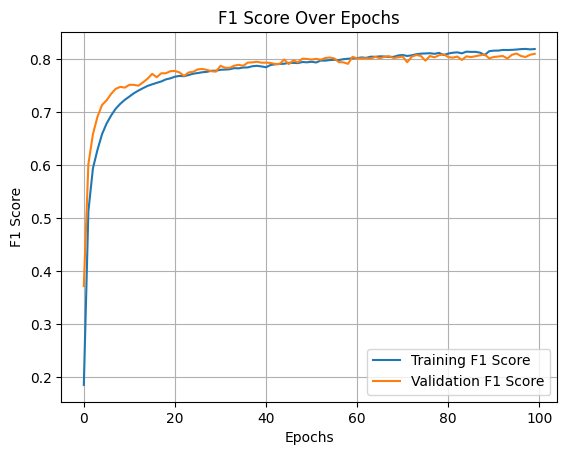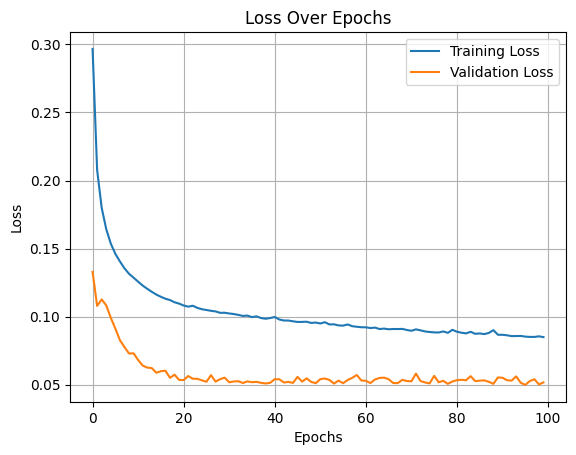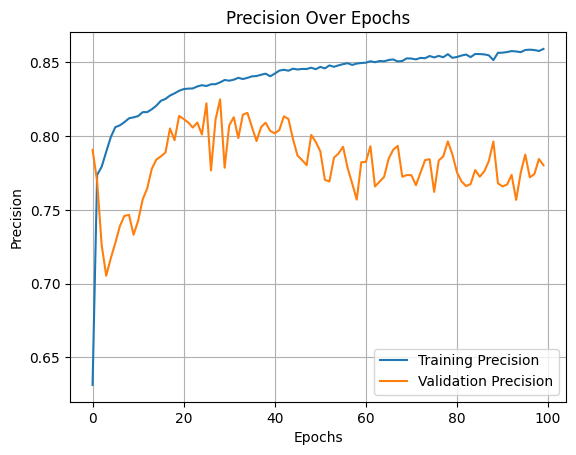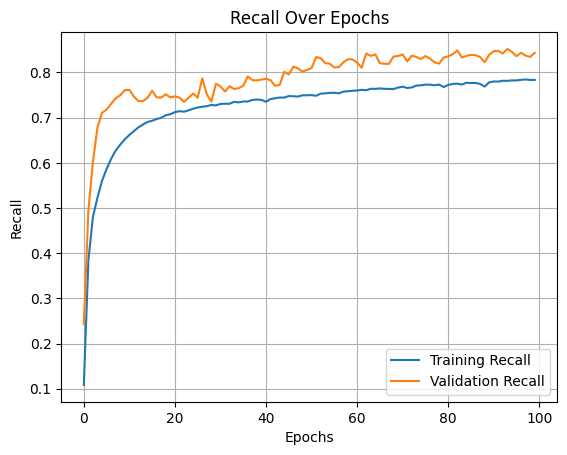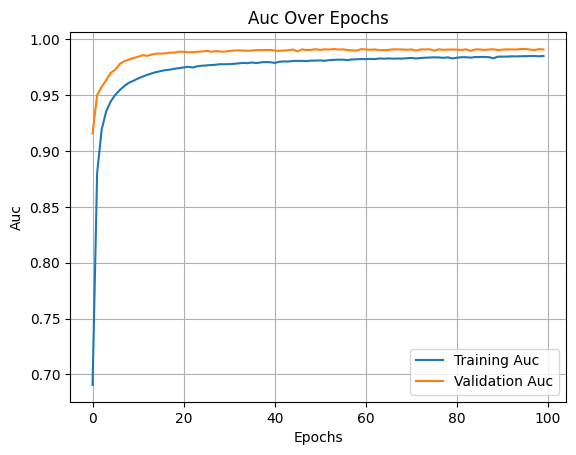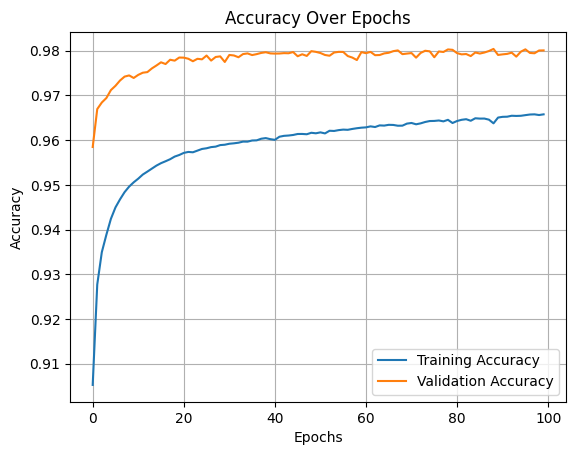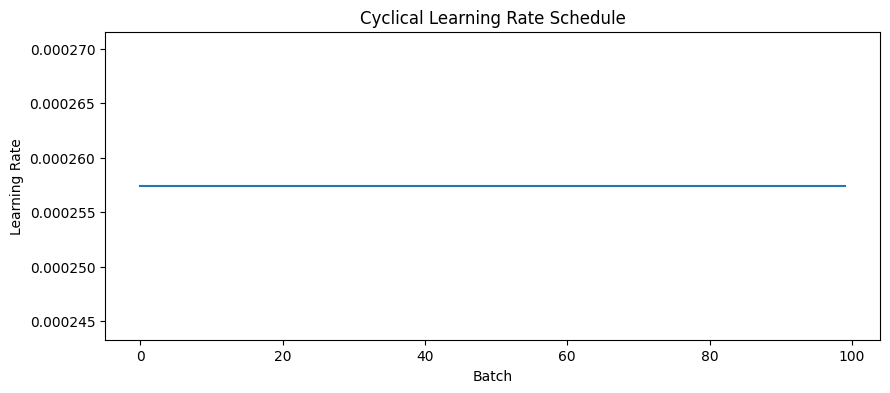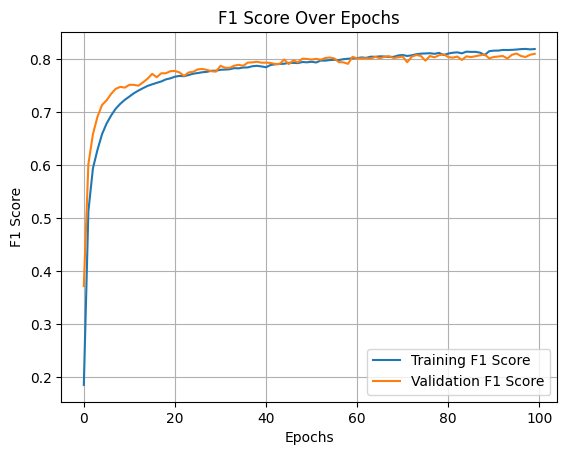